# Using MOCs to track higher order coverage in LSDB

by Sean

In [36]:
import lsdb
import pandas as pd
from hipscat.io.file_io import read_fits_image
import healpy as hp
import numpy as np
import pandas as pd
from mocpy import MOC
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import Angle

## Loading MOC from `point_map.fits`

In [2]:
ztf_path = "/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14"

In [4]:
ztf_fits = read_fits_image(f"{ztf_path}/point_map.fits")
ztf_fits

array([ 722,  644,  811, ..., 1924, 2091, 2119])

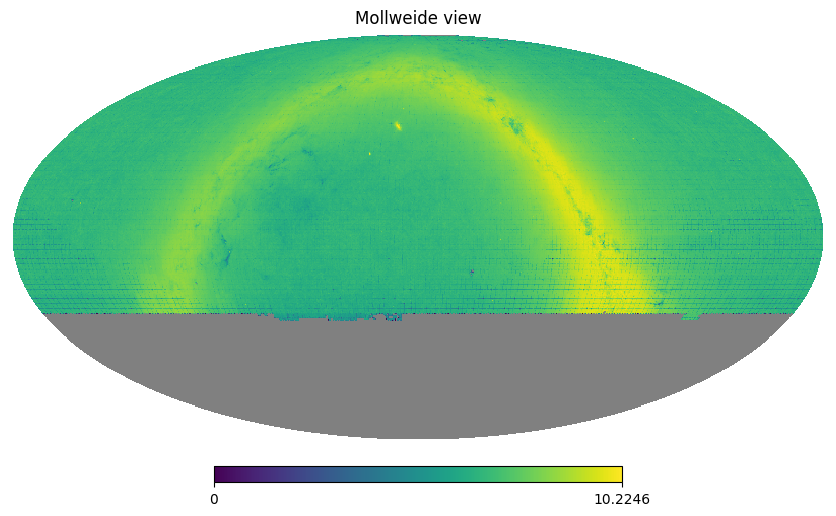

In [6]:
ztf_source_plot_map = ztf_fits.astype(float)
ztf_source_plot_map[ztf_fits == 0] = hp.UNSEEN
ztf_source_plot_map[ztf_fits > 0] = np.log(ztf_source_plot_map[ztf_fits > 0])
hp.mollview(ztf_source_plot_map, nest=True)

In [16]:
order = hp.nside2order(hp.npix2nside(len(ztf_fits)))
ipix = np.where(ztf_fits > 0)[0]
orders = np.full(ipix.shape, order)
moc = MOC.from_healpix_cells(ipix, orders, order)

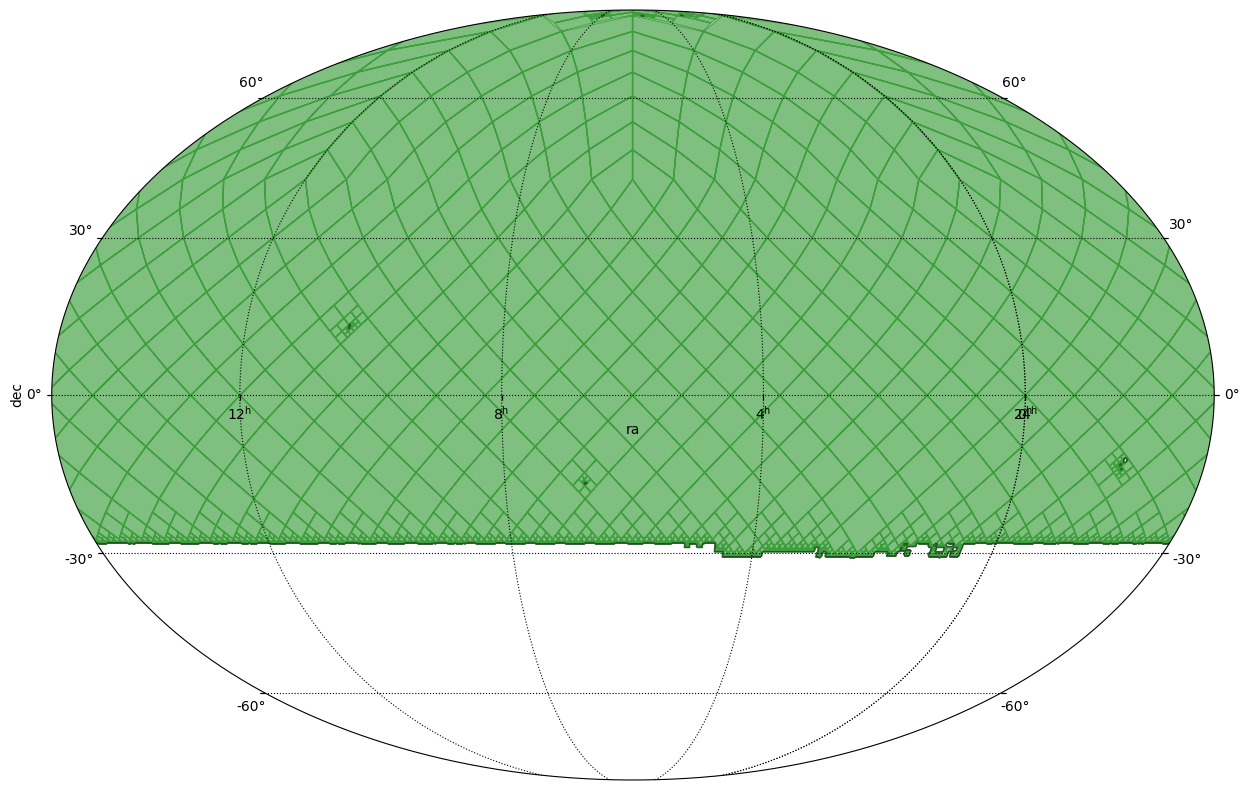

In [34]:
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.coordinates import SkyCoord
from mocpy import WCS

fig = plt.figure(111, figsize=(15, 10))
# Define a astropy WCS easily
with WCS(
        fig,
        fov=160 * u.deg,
        center=SkyCoord(90, 0, unit="deg", frame="icrs"),
        coordsys="icrs",
        rotation=Angle(0, u.degree),
        projection="MOLL",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="green")
    moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
plt.xlabel("ra")
plt.ylabel("dec")
plt.grid(color="black", linestyle="dotted")
plt.show()

In [42]:
ztf = lsdb.read_hipscat(ztf_path)
ztf

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
npartitions=2352,,,,,,,,,,,,,,,
0,int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow]
18014398509481984,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13830554455654793216,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


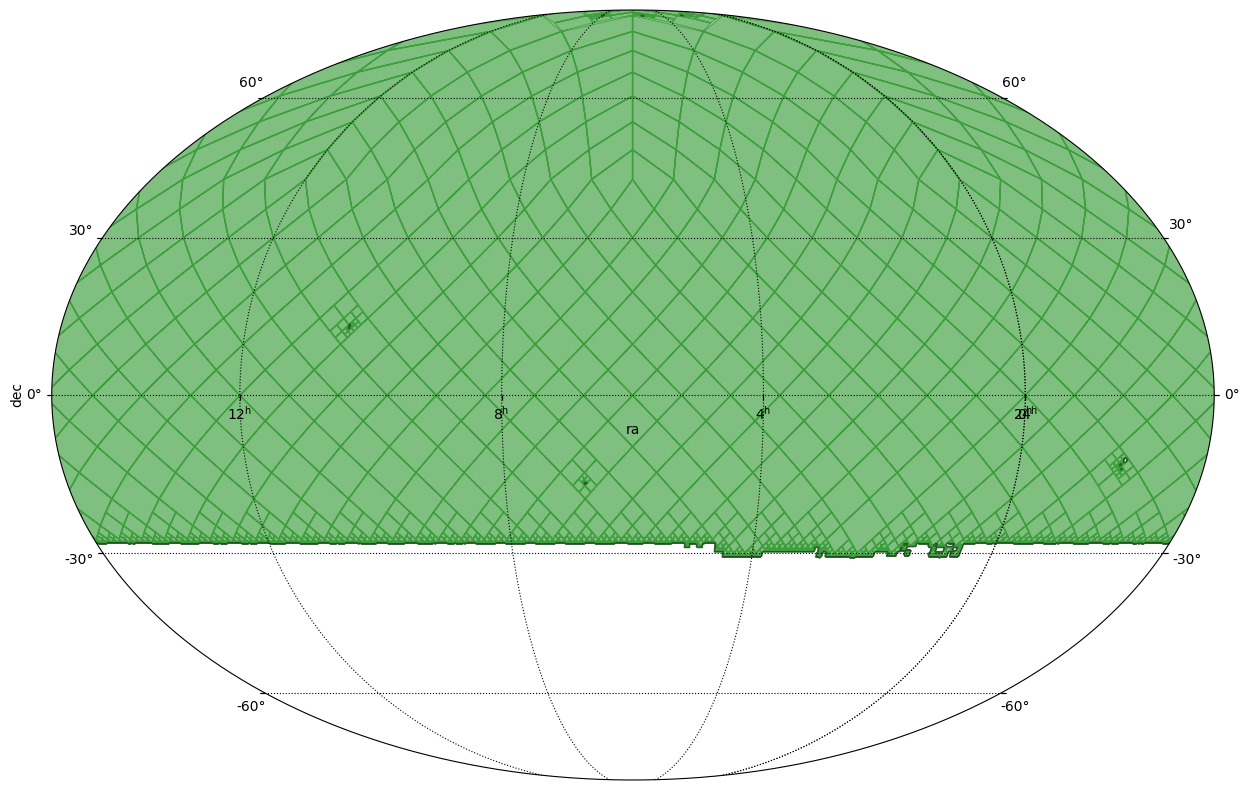

In [43]:
fig = plt.figure(111, figsize=(15, 10))
# Define a astropy WCS easily
with WCS(
        fig,
        fov=160 * u.deg,
        center=SkyCoord(90, 0, unit="deg", frame="icrs"),
        coordsys="icrs",
        rotation=Angle(0, u.degree),
        projection="MOLL",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    ztf.hc_structure.moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="green")
    ztf.hc_structure.moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
plt.xlabel("ra")
plt.ylabel("dec")
plt.grid(color="black", linestyle="dotted")
plt.show()

## Memory Use

In [17]:
ipix.nbytes / 1024 / 1024

4.430412292480469

In [18]:
ztf_fits.nbytes / 1024 / 1024

6.0

In [19]:
moc.to_depth29_ranges.nbytes / 1024 / 1024

0.01055908203125

## Generating a MOC in `from_dataframe`

In [46]:
test_data_ra = np.random.rand(100) * 30
test_data_dec = np.random.rand(100) * 30
test_data_id = np.arange(100)
test_data_df = pd.DataFrame({"ra": test_data_ra, "dec": test_data_dec, "id": test_data_id})
test_data_df

,ra,dec,id
0,13.943765,14.291256,0
1,8.421808,22.730577,1
2,14.622679,0.330853,2
3,28.704936,14.070397,3
4,2.871878,4.022895,4
...,...,...,...
95,20.329479,14.709084,95
96,7.623546,26.201828,96
97,26.199089,3.311344,97
98,21.031998,25.724645,98


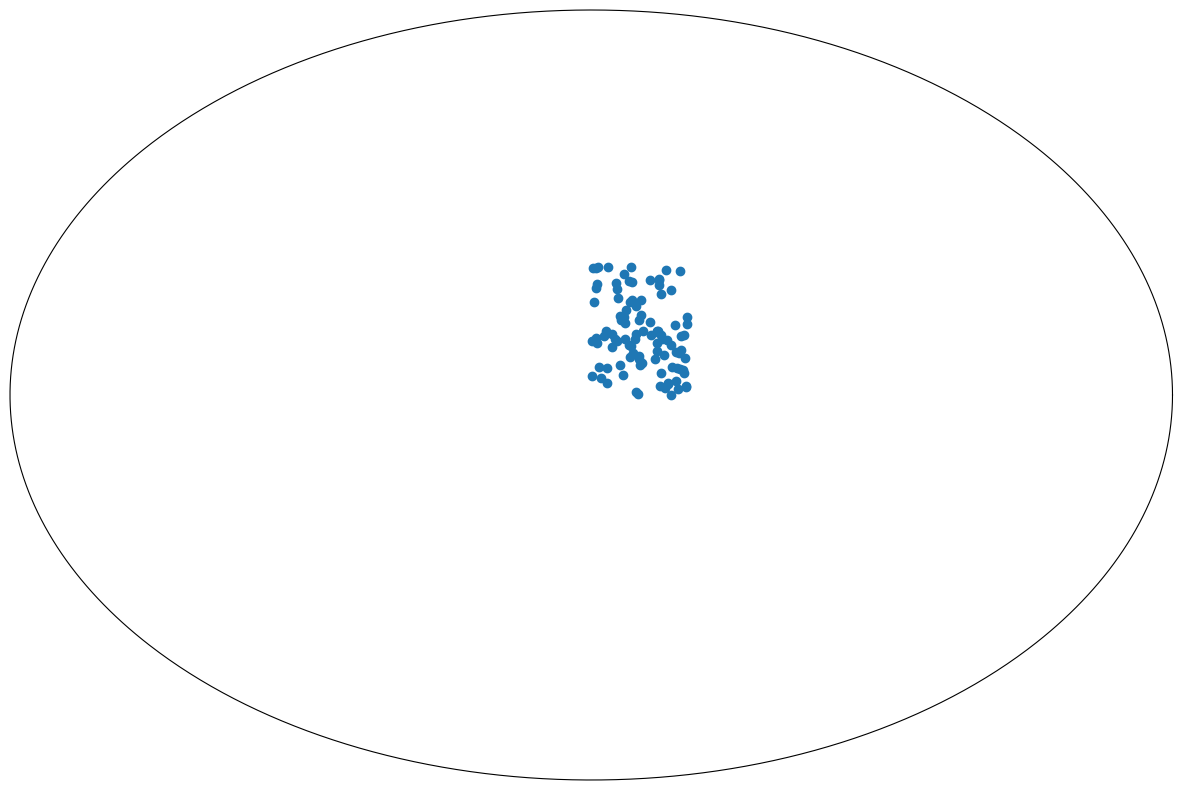

In [47]:

fig = plt.figure(111, figsize=(15, 10))
# Define a astropy WCS easily
with WCS(
        fig,
        fov=160 * u.deg,
        center=SkyCoord(90, 0, unit="deg", frame="icrs"),
        coordsys="icrs",
        rotation=Angle(0, u.degree),
        projection="MOLL",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    ax.scatter(test_data_ra, test_data_dec)
plt.xlabel("ra")
plt.ylabel("dec")
plt.grid(color="black", linestyle="dotted")
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()

In [48]:
test_data = lsdb.from_dataframe(test_data_df)
test_data

,ra,dec,id,Norder,Dir,Npix
npartitions=2,,,,,,
0,double[pyarrow],double[pyarrow],int64[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
4611686018427387904,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...


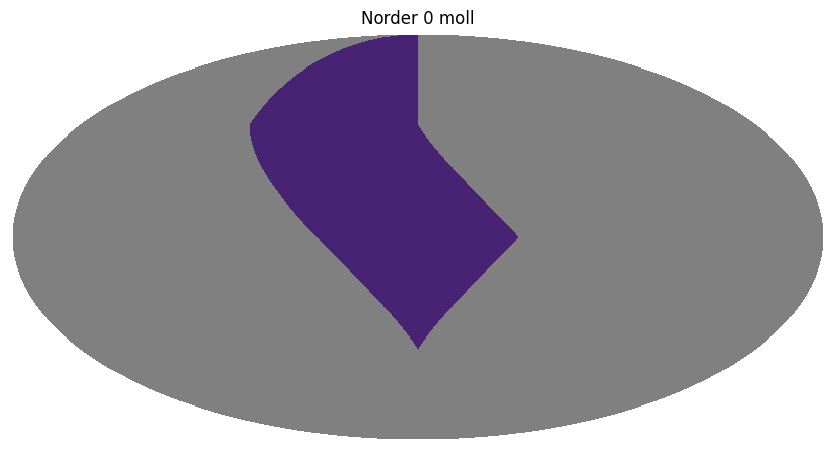

In [49]:
test_data.plot_pixels()

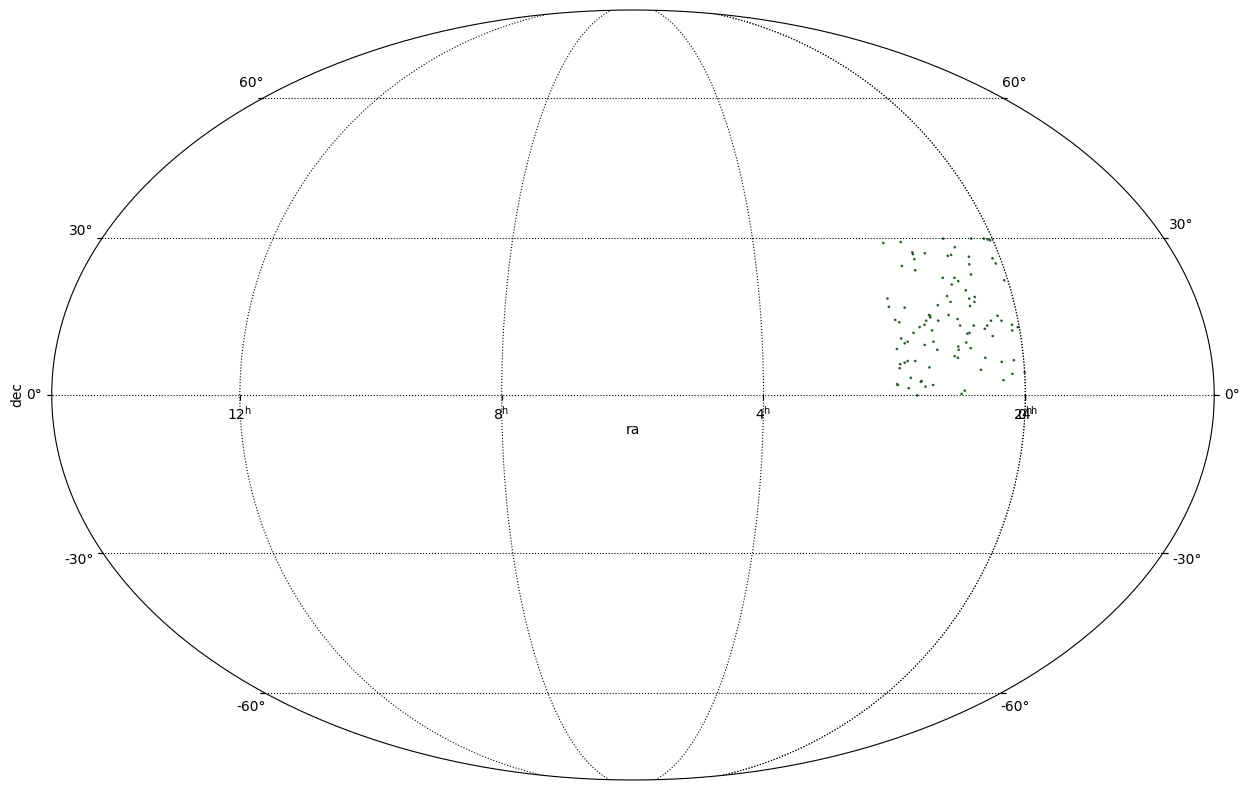

In [50]:
fig = plt.figure(111, figsize=(15, 10))
# Define a astropy WCS easily
with WCS(
        fig,
        fov=160 * u.deg,
        center=SkyCoord(90, 0, unit="deg", frame="icrs"),
        coordsys="icrs",
        rotation=Angle(0, u.degree),
        projection="MOLL",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    test_data.hc_structure.moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="green")
    test_data.hc_structure.moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
plt.xlabel("ra")
plt.ylabel("dec")
plt.grid(color="black", linestyle="dotted")
plt.show()

In [51]:
test_data_no_moc = lsdb.from_dataframe(test_data_df, should_generate_moc=False)
test_data_no_moc

,ra,dec,id,Norder,Dir,Npix
npartitions=2,,,,,,
0,double[pyarrow],double[pyarrow],int64[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
4611686018427387904,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...


In [53]:
test_data_no_moc.hc_structure.moc is None

True

## Crossmatching using MOCs

/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


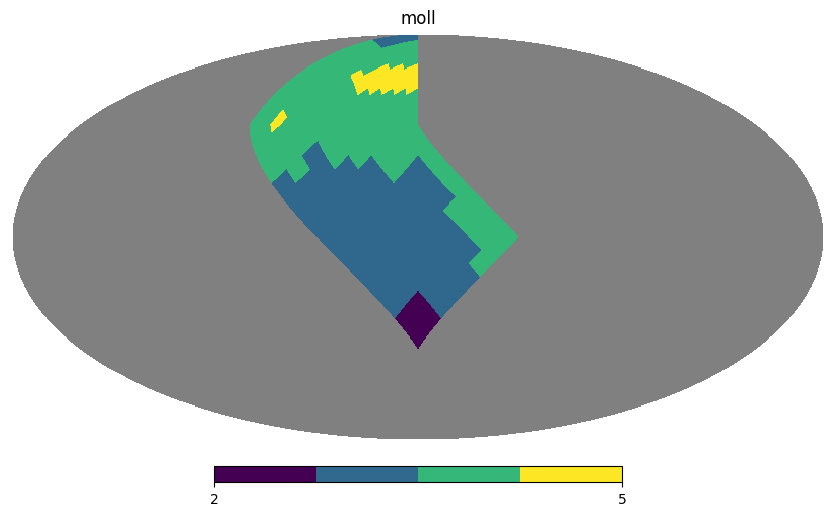

In [55]:
ztf.crossmatch(test_data_no_moc).plot_pixels()

/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


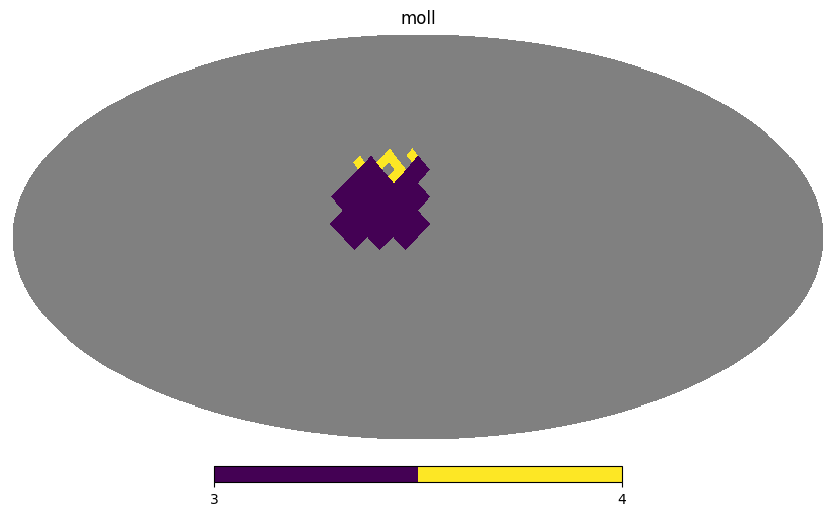

In [56]:
ztf.crossmatch(test_data).plot_pixels()

In [59]:
print(ztf.crossmatch(test_data)._ddf.npartitions)
print(ztf.crossmatch(test_data_no_moc)._ddf.npartitions)

/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


26
377


In [57]:
ztf_source = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source/")
ztf_source

,index,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
npartitions=311037,,,,,,,,,,,,,,,,,,,,,,,
0,int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],int16[pyarrow],string[pyarrow],int32[pyarrow],int32[pyarrow],int32[pyarrow]
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834987686537986048,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


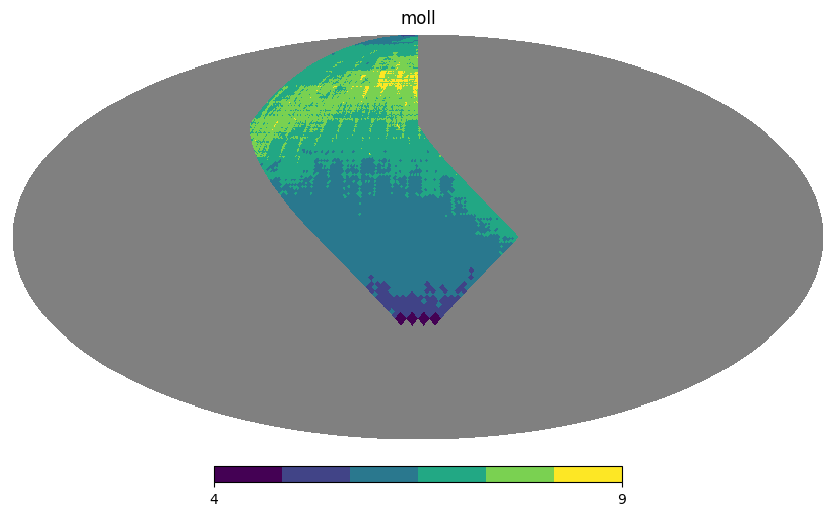

In [61]:
ztf_source.crossmatch(test_data_no_moc).plot_pixels()

/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


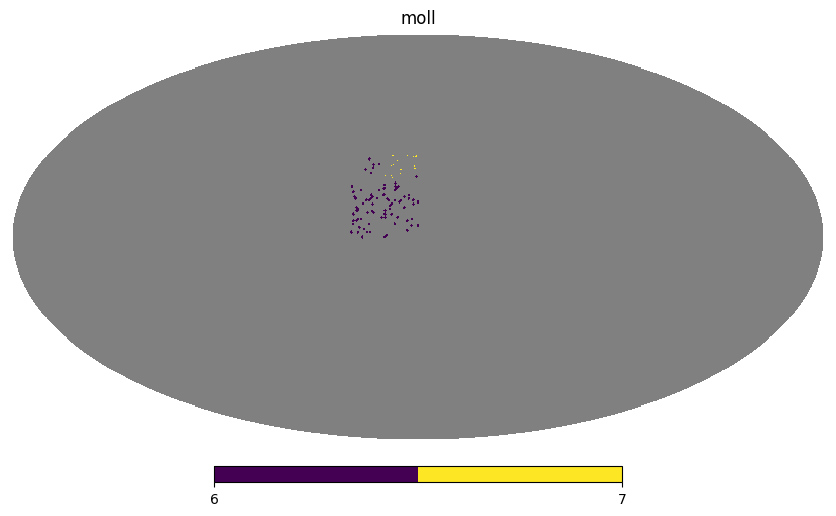

In [58]:
test_data.crossmatch(ztf_source).plot_pixels()

In [62]:
print(ztf_source.crossmatch(test_data)._ddf.npartitions)
print(ztf_source.crossmatch(test_data_no_moc)._ddf.npartitions)

/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


95


/astro/users/seanmcgu/lsdb_deploy/src/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


40742
